In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataframe = pandas.read_csv('winequality-red.csv', sep=';')
dataframe

# Separate features and target
X = dataframe.drop('quality', axis=1)
y = dataframe['quality']

# Display basic information
print("Dataset shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature names:", X.columns.tolist())
print("\nTarget name:", 'quality')

In [ ]:
red_wine = X
red_wine_quality = pd.DataFrame(y, columns=['quality'])


In [ ]:
# Display basic statistics
print("Red Wine Dataset Statistics")
print(red_wine.describe())

In [ ]:
# Check for missing values
print("\nMissing values:", red_wine.isnull().sum().sum())

In [ ]:
# Visualize distributions
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(red_wine.columns):
    axes[idx].hist(red_wine[col], bins=30, edgecolor='black')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Target distribution
plt.figure(figsize=(10, 6))
red_wine_quality['quality'].value_counts().sort_index().plot(kind='bar')
plt.title('Wine Quality Distribution')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()

In [ ]:
# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = dataframe.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# 2. DATA PREPROCESSING

# Assign numbers to the data(good vs bad wine)
# Good wine: quality >= 6, Bad wine: quality < 6
y_binary = (red_wine_quality['quality'] >= 6).astype(int)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(red_wine, y_binary, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y_binary)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")

In [ ]:
# 3. MODEL DEVELOPMENT

# K-Nearest Neighbors Classifier

knn_clf = KNeighborsClassifier()

# Define parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Grid search with cross-validation
knn_grid_search = GridSearchCV(knn_clf, knn_param_grid, cv=5, 
                               scoring='f1', n_jobs=-1, verbose=1)
knn_grid_search.fit(X_train_scaled, y_train)

print("\nBest KNN parameters:", knn_grid_search.best_params_)
print("Best KNN cross-validation score:", knn_grid_search.best_score_)

In [ ]:
# Evaluate best KNN model
best_knn = knn_grid_search.best_estimator_
knn_pred = best_knn.predict(X_test_scaled)

In [ ]:
#Multi-Layer Perceptron Classifier

mlp_clf = MLPClassifier(random_state=42, max_iter=1000)

# Define parameter grid for MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

In [ ]:
# Grid search with cross-validation
mlp_grid_search = GridSearchCV(mlp_clf, mlp_param_grid, cv=5, 
                               scoring='f1', n_jobs=-1, verbose=1)
mlp_grid_search.fit(X_train_scaled, y_train)

print("\nBest MLP parameters:", mlp_grid_search.best_params_)
print("Best MLP cross-validation score:", mlp_grid_search.best_score_)

# Evaluate best MLP model
best_mlp = mlp_grid_search.best_estimator_
mlp_pred = best_mlp.predict(X_test_scaled)

In [ ]:
# 4. MODEL EVALUATION
def evaluate_classifier(y_true, y_pred, model_name):
    """Evaluate classifier performance with multiple metrics"""
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
     # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
 # ROC curve
    if hasattr(best_knn, "predict_proba"):
        y_prob = best_knn.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = best_knn.decision_function(X_test_scaled)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Evaluate both models
evaluate_classifier(y_test, knn_pred, "K-Nearest Neighbors")
evaluate_classifier(y_test, mlp_pred, "Multi-Layer Perceptron")

In [ ]:
# 5. REGRESSION ANALYSIS

# For regression, I used the actual quality scores 
y_reg = red_wine_quality['quality']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    red_wine, y_reg, test_size=0.2, random_state=42)

# Scale features
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

In [ ]:
# 5.1 KNN Regressor

knn_reg = KNeighborsRegressor()

# Parameter grid for KNN regressor
knn_reg_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Grid search
knn_reg_grid = GridSearchCV(knn_reg, knn_reg_param_grid, cv=5, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
knn_reg_grid.fit(X_train_reg_scaled, y_train_reg)

# Best model
best_knn_reg = knn_reg_grid.best_estimator_
knn_reg_pred = best_knn_reg.predict(X_test_reg_scaled)

In [ ]:
# 5.2 MLP Regressor


mlp_reg = MLPRegressor(random_state=42, max_iter=1000)

# Parameter grid for MLP regressor
mlp_reg_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Grid search
mlp_reg_grid = GridSearchCV(mlp_reg, mlp_reg_param_grid, cv=5, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
mlp_reg_grid.fit(X_train_reg_scaled, y_train_reg)

# Best model
best_mlp_reg = mlp_reg_grid.best_estimator_
mlp_reg_pred = best_mlp_reg.predict(X_test_reg_scaled)

In [ ]:
# Evaluate regression models
def evaluate_regressor(y_true, y_pred, model_name):
    """Evaluate regressor performance"""
    print(f"\n=== {model_name} Regression Evaluation ===")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")

In [ ]:
# Evaluate regression models
evaluate_regressor(y_test_reg, knn_reg_pred, "KNN")
evaluate_regressor(y_test_reg, mlp_reg_pred, "MLP")


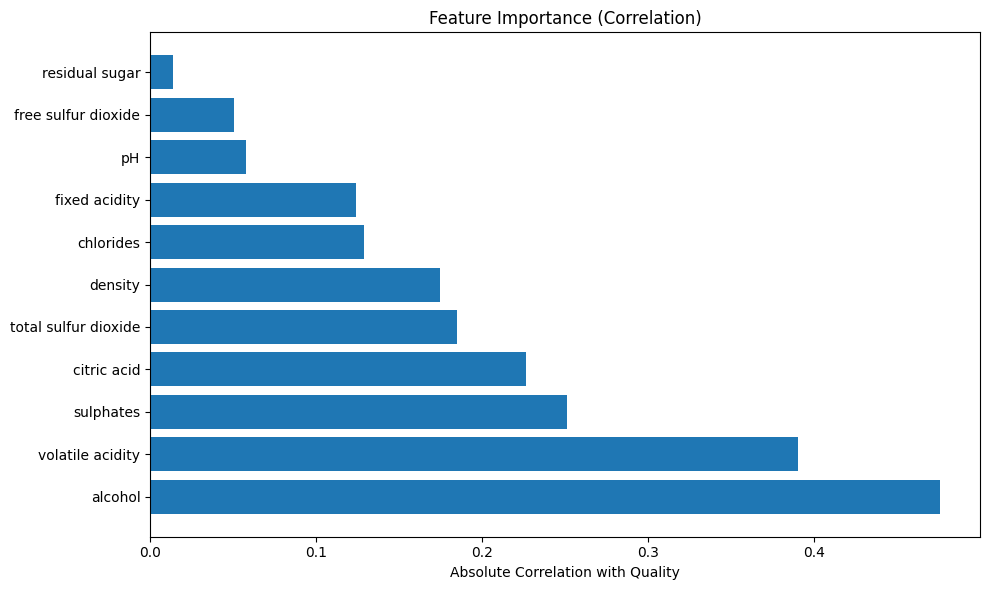

In [128]:
# 6. Analysis of features

#IF it correlates with the target 
feature_importance = pd.DataFrame({
    'Feature': red_wine.columns,
    'Correlation': [abs(red_wine[col].corr(red_wine_quality['quality'])) 
                   for col in red_wine.columns]
}).sort_values('Correlation', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Correlation'])
plt.xlabel('Absolute Correlation with Quality')
plt.title('Feature Importance (Correlation)')
plt.tight_layout()
plt.show()

In [129]:
# 7. FINAL MODEL COMPARISON
# ========================

results_df = pd.DataFrame({
    'Model': ['KNN Classifier', 'MLP Classifier', 'KNN Regressor', 'MLP Regressor'],
    'Task': ['Classification', 'Classification', 'Regression', 'Regression'],
    'Primary Metric': [
        f1_score(y_test, knn_pred),
        f1_score(y_test, mlp_pred),
        -mean_squared_error(y_test_reg, knn_reg_pred),
        -mean_squared_error(y_test_reg, mlp_reg_pred)
    ],
    'Best Parameters': [
        str(knn_grid_search.best_params_),
        str(mlp_grid_search.best_params_),
        str(knn_reg_grid.best_params_),
        str(mlp_reg_grid.best_params_)
    ]
})

print("\n=== Final Model Comparison ===")
print(results_df)


NameError: name 'mlp_reg_pred' is not defined

In [ ]:
# Save results
results_df.to_csv('model_comparison_results.csv', index=False)